In [5]:
#%matplotlib notebook

import numpy as np
import inspect
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy.constants import physical_constants
from scipy.optimize import curve_fit
from sopes import Table
from scipy.integrate import quad
from scipy.ndimage import gaussian_filter, rotate

from sopes import Table

from mpl_toolkits.mplot3d import Axes3D  

ModuleNotFoundError: No module named 'sopes'

In [3]:
# Boltzmann constant in SESAME units kJ/K
kB = physical_constants['Boltzmann constant'][0] / 1000. #turning this into kiloJoules because SESAME energy data is in that units
# the lowercase k is standard for constant 


###############################################################################
# Getting the SESAME data
###############################################################################

# Set up the P-T table
P_of_RT = Table('EOS_Pt_DT', 5267) #pressure table as a function of RT, the R stands for rho (density)
e_of_RT = Table('EOS_Ut_DT', 5267) #internal energy (U) table as a function of RT
P_of_Re = Table('EOS_Pt_DUt', 5267) #Pressure table as a function of R (density) and e(internal energy)
ecold_of_R = Table('EOS_Uc_D', 5267) #Loads the cold curve as a function of density e_cold(rho)

# Get the density-temperature grid from SESAME tables
nR, nT = [int(val) for val in P_of_RT.info_many(['NR', 'NT'])] #getting the nR (number of density points) and nT
T_grid = np.array(P_of_RT.info_one('T_Array')) #retrives actual values
density_grid = np.array(P_of_RT.info_one('R_Array'))
density_points, temp_points = np.meshgrid(density_grid, T_grid, indexing='ij') #each are nR x nT

# Get the values on the grid
P_on_grid, _, _ = P_of_RT.interpolate_many(density_points.flatten(),
                                           temp_points.flatten()) #the _, _ just means ignore the other 2 return values
P_on_grid = P_on_grid.reshape(nR, nT)
e_on_grid, dedr_T, dedT_R = e_of_RT.interpolate_many(density_points.flatten(),
                                                     temp_points.flatten()) #finds pressure at every coordinate
e_on_grid = e_on_grid.reshape(nR, nT) 
Cv_on_grid = dedT_R.reshape(nR, nT)

# Get the cold curve. Note that we're interpolating on nR x nT points here.
# Also note that the temperature points are irrelevant
ecold_on_grid, _, _ = ecold_of_R.interpolate_many(density_points.flatten(),
                                                  temp_points.flatten()) #does the same lookups for energy, interpolates using 4 points
ecold_on_grid = ecold_on_grid.reshape(nR, nT)

NameError: name 'Table' is not defined

In [3]:
e_on_grid.shape

(209, 98)

In [4]:
T_grid.shape

(98,)

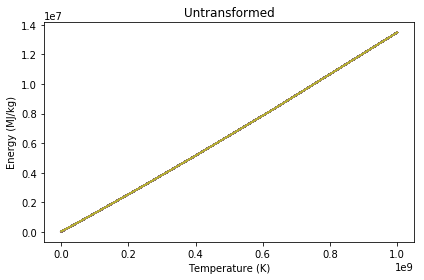

In [5]:
# Plot the various versions of the table
fig, ax = plt.subplots()
ax.set_title("Untransformed")
ax.set_ylabel("Energy (MJ/kg)")
ax.set_xlabel("Temperature (K)")
#ax.set_xscale('symlog', linthresh=10)
#ax.set_yscale('symlog', linthresh=10e5) 
for i in range(nR):  
    ax.plot(T_grid, e_on_grid[i, :], label=f"ρ = {density_grid[i]:.2f}")
#ax.legend(title="Density (g/cc)", fontsize='small', loc='best')
#density_lims = ax.get_xlim()
#energy_lims = ax.get_ylim()
fig.tight_layout()

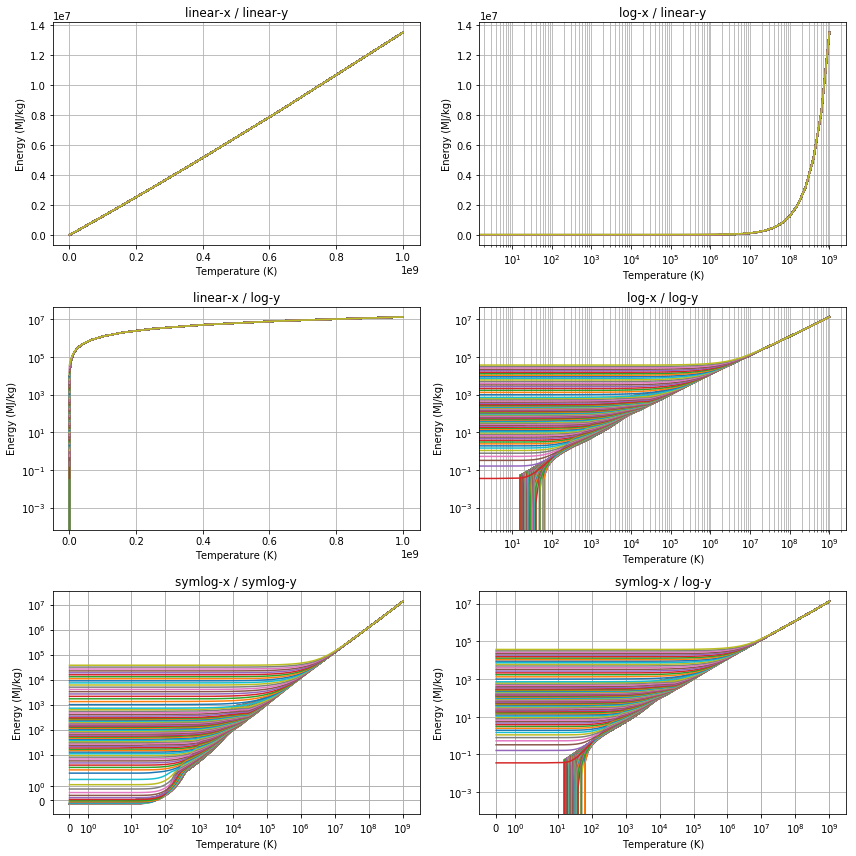

In [5]:
scales = [
    ("linear", "linear"),
    ("log", "linear"),
    ("linear", "log"),
    ("log", "log"),
    ("symlog", "symlog"), 
    ("symlog", "log") ]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, (xscale, yscale) in zip(axes, scales):
    for i, rho in enumerate(density_grid):
        ax.plot(T_grid, e_on_grid[i], label=f"ρ = {rho}")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_title(f"{xscale}-x / {yscale}-y")
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Energy (MJ/kg)")
    #ax.legend(fontsize="small")
    ax.grid(True, which='both')

fig.tight_layout()
plt.show()


# Subtracting Cold Curve and scaling axis

In [6]:
# First: subtract cold curve from energies
e_minus_cold_on_grid = e_on_grid - ecold_on_grid

In [7]:
from matplotlib.scale import ScaleBase
from matplotlib.transforms import Transform
from matplotlib import scale as mscale

class ArcSinhTransform(Transform):
    input_dims = output_dims = 1

    def transform_non_affine(self, a):
        return np.arcsinh(a)

    def inverted(self):
        return InvertedArcSinhTransform()

class InvertedArcSinhTransform(Transform):
    input_dims = output_dims = 1

    def transform_non_affine(self, a):
        return np.sinh(a)

    def inverted(self):
        return ArcSinhTransform()

class ArcSinhScale(ScaleBase):
    name = 'arcsinh'

    def get_transform(self):
        return ArcSinhTransform()

    def set_default_locators_and_formatters(self, axis):
        import matplotlib.ticker as ticker
        axis.set_major_locator(ticker.MaxNLocator(nbins=2, prune='both'))


    def limit_range_for_scale(self, vmin, vmax, minpos):
        return vmin, vmax

# Register the scale with Matplotlib
mscale.register_scale(ArcSinhScale)


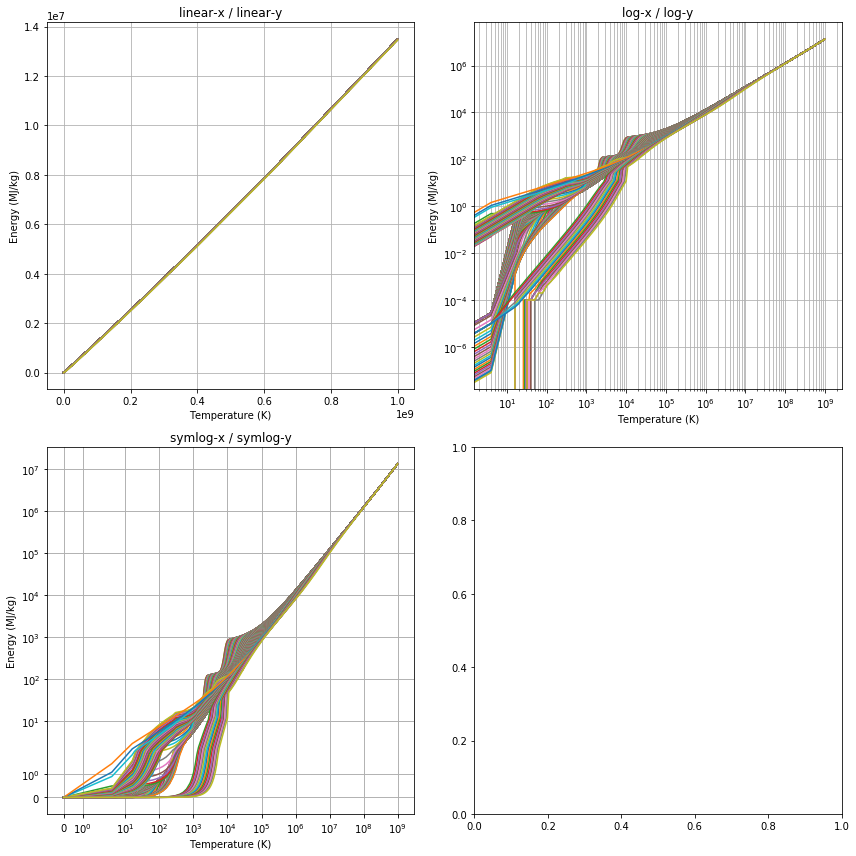

In [8]:

scales = [
    ("linear", "linear"),
    ("log", "log"),
    ("symlog", "symlog"),
#     ("arcsinh", "arcsinh")  # Custom scale
]


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, (xscale, yscale) in zip(axes, scales):
    for i, rho in enumerate(density_grid):
        ax.plot(T_grid, e_minus_cold_on_grid[i], label=f"ρ = {rho}")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_title(f"{xscale}-x / {yscale}-y")
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Energy (MJ/kg)")
    #ax.legend(fontsize="small")
    ax.grid(True, which='both')

fig.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


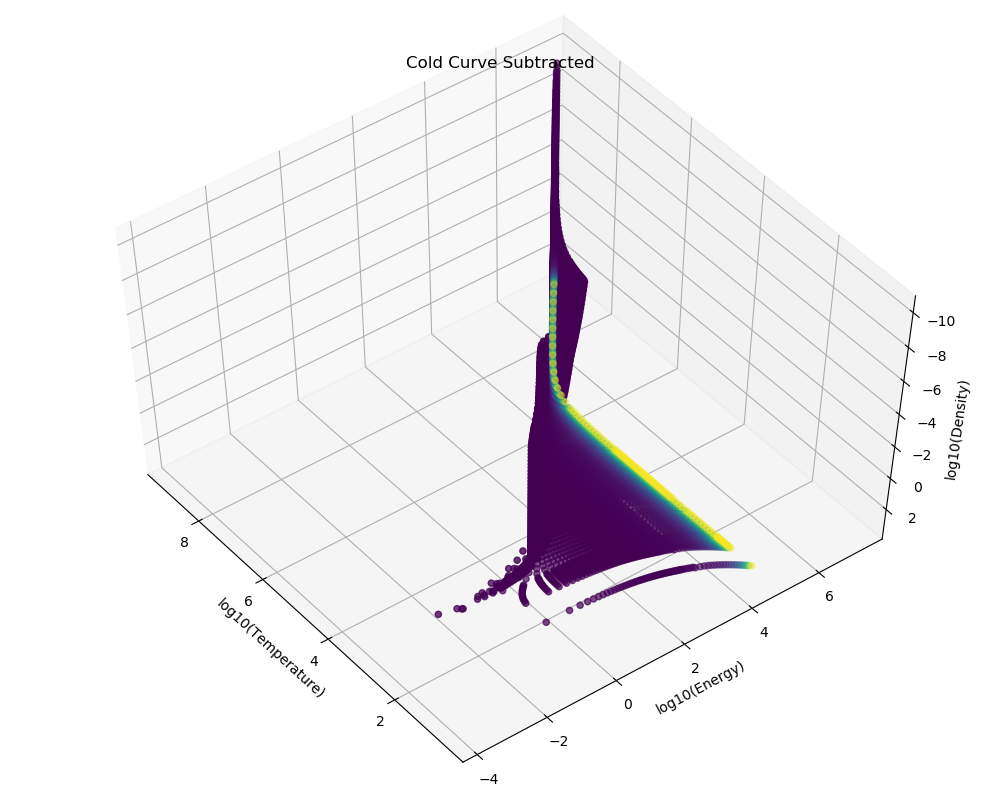

/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


In [7]:
%matplotlib notebook
T = np.array(T_grid)
rho = np.array(density_grid)
E = np.array(e_on_grid)

T_mesh, rho_mesh = np.meshgrid(T, rho)

X = T_mesh.flatten()
Y = E.flatten()
Z = rho_mesh.flatten()



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.log10(X), np.log10(Y), np.log10(Z), c=Z, cmap='viridis')

ax.set_xlabel('log10(Temperature)')
ax.set_ylabel('log10(Energy)')
ax.set_zlabel('log10(Density)')
ax.view_init(elev=30, azim=160)

ax.set_title("Cold Curve Subtracted")
plt.tight_layout()
plt.show()


/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


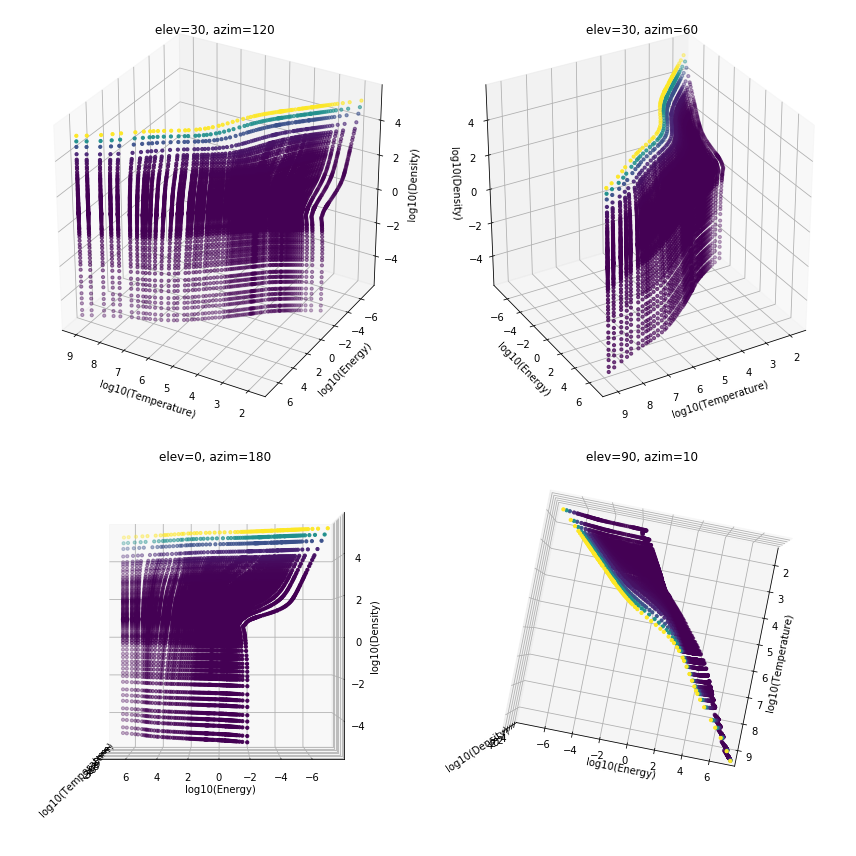

In [11]:
views = [
    (30, 120),
    (30, 60),
    (0, 180),
    (90, 10) 
]

fig = plt.figure(figsize=(12, 12))

for i, (elev, azim) in enumerate(views):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax.scatter(np.log10(X), np.log10(Y), np.log10(Z), c=Z, cmap='viridis', s=10)
    ax.set_xlabel('log10(Temperature)')
    ax.set_ylabel('log10(Energy)')
    ax.set_zlabel('log10(Density)')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f"elev={elev}, azim={azim}")

plt.tight_layout()
plt.show()



## Divide by Heat Capacity

In [9]:
min_Cv = 1.0e-08  # MJ / K / kg
e_transform = e_minus_cold_on_grid / np.maximum(Cv_on_grid, min_Cv)

/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


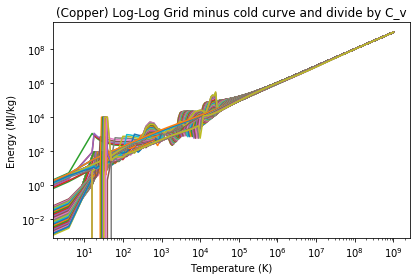

In [10]:
fig, ax = plt.subplots()
ax.set_title("(Copper) Log-Log Grid minus cold curve and divide by C_v")
ax.set_ylabel("Energy (MJ/kg)")
ax.set_xlabel("Temperature (K)")
for i in range(nR):  
    ax.plot(T_grid, e_transform[i, :], 
    label=f"ρ = {density_grid[i]:.2f}, log10(ρ) = {np.log10(density_grid[i]):.2f}")
    ax.set_xscale("log")
    ax.set_yscale("log")
fig.tight_layout()
#fig.legend(ncol=3, loc='upper right') # Arrange in 3 columns

/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


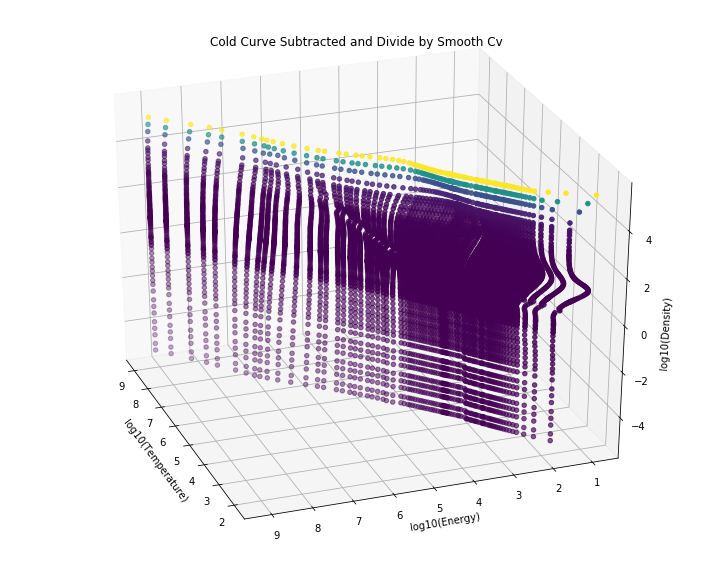

In [4]:
min_Cv = 1.0e-08  # MJ / K / kg
e_transform = e_minus_cold_on_grid / np.maximum(Cv_on_grid, min_Cv)

T = np.array(T_grid)
rho = np.array(density_grid)
E = np.array(e_transform)

T_mesh, rho_mesh = np.meshgrid(T, rho)

X = T_mesh.flatten()
Y = E.flatten()
Z = rho_mesh.flatten()



fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.log10(X), np.log10(Y), np.log10(Z), c=Z, cmap='viridis')

ax.set_xlabel('log10(Temperature)')
ax.set_ylabel('log10(Energy)')
ax.set_zlabel('log10(Density)')
ax.view_init(elev=30, azim=160)

ax.set_title("Cold Curve Subtracted and Divide by Smooth Cv")
plt.tight_layout()
plt.show()


/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


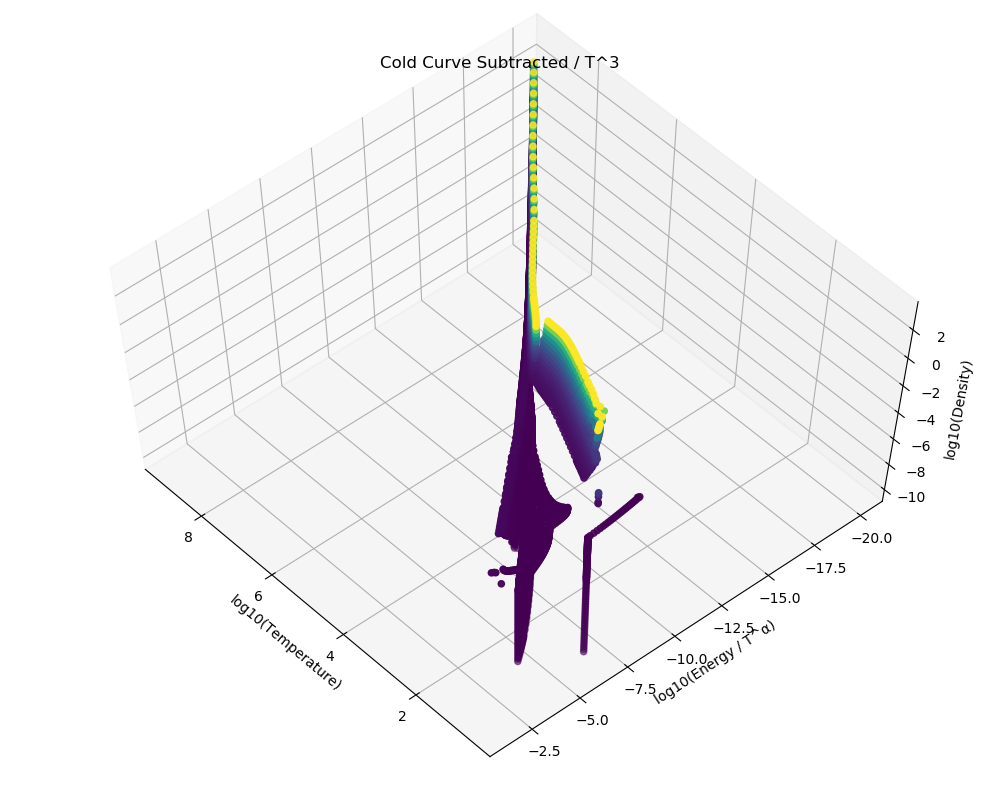

/vast/home/eoneil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


In [13]:
# Parameters
min_Cv = 1.0e-08  # MJ / K / kg
alpha = 3       # T-scaling exponent

# Convert to arrays
T = np.array(T_grid)  # shape: (n_T,)
rho = np.array(density_grid)  # shape: (n_rho,)
Cv = np.maximum(Cv_on_grid, min_Cv)  # ensure numerical stability

# Compute normalized energy
e_transform = e_minus_cold_on_grid #/ Cv  # shape: (n_rho, n_T)

# Add T^α normalization
# We need to expand T to match the grid shape
T_expanded = np.tile(T, (rho.size, 1))  # shape: (n_rho, n_T)
e_T_scaled = e_transform / np.power(T_expanded, alpha)

# Flatten for plotting
T_mesh, rho_mesh = np.meshgrid(T, rho)
X = T_mesh.flatten()
Y = e_T_scaled.flatten()
Z = rho_mesh.flatten()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.log10(X), np.log10(Y), np.log10(Z), c=Z, cmap='viridis')

ax.set_xlabel('log10(Temperature)')
ax.set_ylabel('log10(Energy / T^α)')
ax.set_zlabel('log10(Density)')
ax.view_init(elev=30, azim=160)

ax.set_title(f"Cold Curve Subtracted / T^{alpha}")
plt.tight_layout()
plt.show()


### Fitting Heat model

<IPython.core.display.Javascript object>


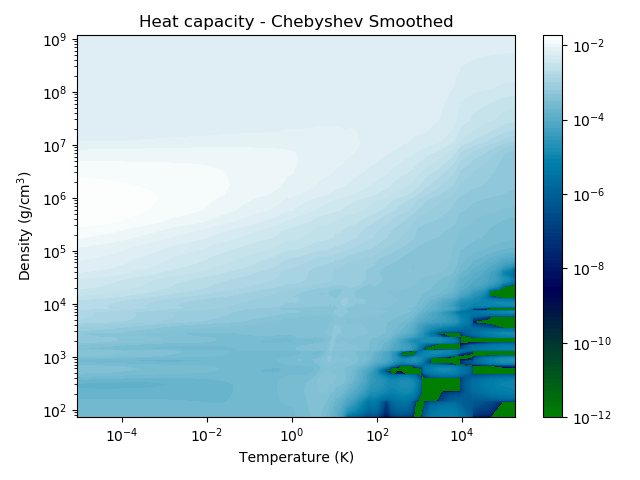

In [102]:
from scipy.fftpack import dct, idct

def dct2(a):
    """2D Discrete Cosine Transform (DCT Type-II)"""
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    """2D Inverse Discrete Cosine Transform (DCT Type-III)"""
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

# --- Apply 2D DCT to get Chebyshev coefficients ---
coeffs = dct2(Cv_on_grid)

# --- Truncate high-frequency coefficients (smoothing) ---
k = 20  # Choose lower-rank approximation (like a low-pass filter)
coeffs_trunc = np.zeros_like(coeffs)
coeffs_trunc[:k, :k] = coeffs[:k, :k]

# --- Reconstruct smoothed data using inverse DCT ---
Cv_smooth = idct2(coeffs_trunc)
Cv_smooth = np.clip(Cv_smooth, a_min=1e-12, a_max=None)  # avoid log(0)



# --- Plot Results ---


fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity - Chebyshev Smoothed")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_smooth)),
                     np.log10(np.max(Cv_smooth)),
                     100)
cplot = ax.contourf(density_points, temp_points, Cv_smooth, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()

In [ ]:
#pip install --upgrade scipy scikit-learn


<IPython.core.display.Javascript object>


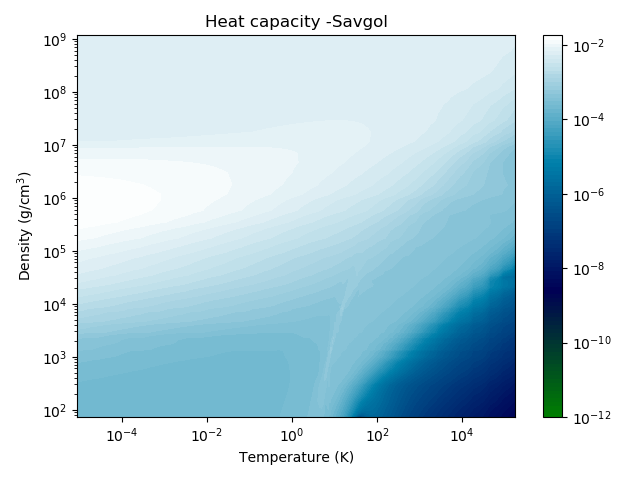

In [100]:
from scipy.signal import savgol_filter

# Apply separately in each direction
Cv_smooth = savgol_filter(Cv_on_grid, window_length=3, polyorder=2, axis=0)
Cv_smooth = savgol_filter(Cv_smooth, window_length=19, polyorder=5,axis=1)
Cv_smooth = np.clip(Cv_smooth, a_min=1e-12, a_max=None)  # avoid log(0)

fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity -Savgol")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_smooth)),
                     np.log10(np.max(Cv_smooth)),
                     100)
cplot = ax.contourf(density_points, temp_points, Cv_smooth, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()

/vast/home/eoneil/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


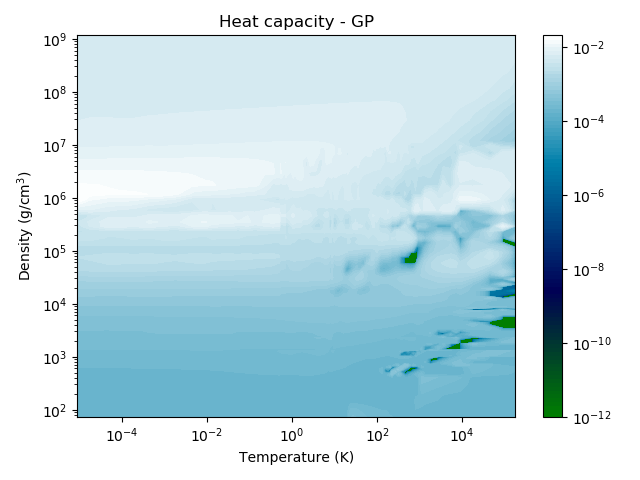

In [104]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Create coordinate pairs and values
coords = np.column_stack((X.ravel(), Y.ravel()))
values = Cv_on_grid.ravel()

# Fit GP model
gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.1), alpha=1e-6)
gp.fit(coords, values)

# Predict smoothed data
Cv_smooth = gp.predict(coords).reshape(Cv_on_grid.shape)
Cv_smooth = np.clip(Cv_smooth, a_min=1e-12, a_max=None)  # avoid log(0)


fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity - GP")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_smooth)),
                     np.log10(np.max(Cv_smooth)),
                     100)
cplot = ax.contourf(density_points, temp_points, Cv_smooth, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()

<IPython.core.display.Javascript object>


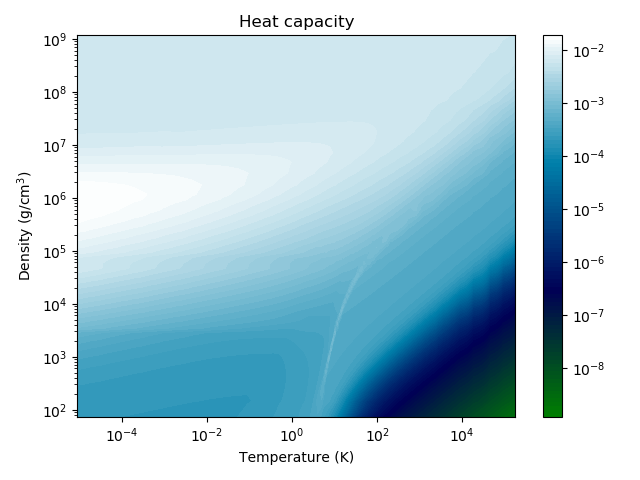

In [27]:
fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_on_grid)),
                     np.log10(np.max(Cv_on_grid)),
                     100)
cplot = ax.contourf(density_points, temp_points, Cv_on_grid, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()


<IPython.core.display.Javascript object>


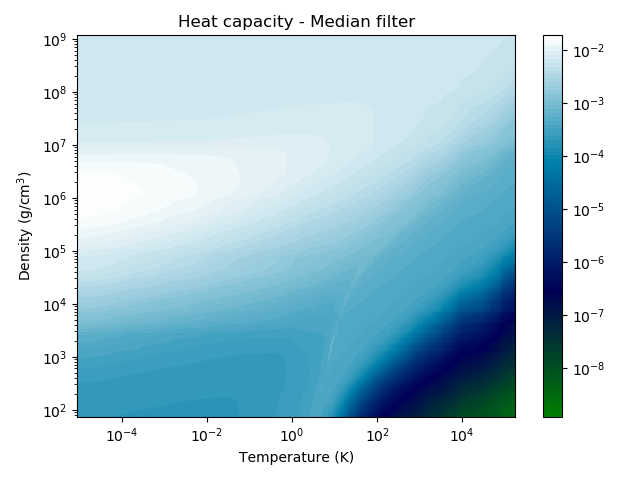

In [35]:
from scipy.ndimage import median_filter, gaussian_filter
#from skimage import data, util

# Apply median filter
filtered_Cv = median_filter(Cv_on_grid, size=4)  # 3x3 window

fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity - Median filter")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_on_grid)),
                     np.log10(np.max(Cv_on_grid)),
                     100)
cplot = ax.contourf(density_points, temp_points, filtered_Cv, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()



<IPython.core.display.Javascript object>


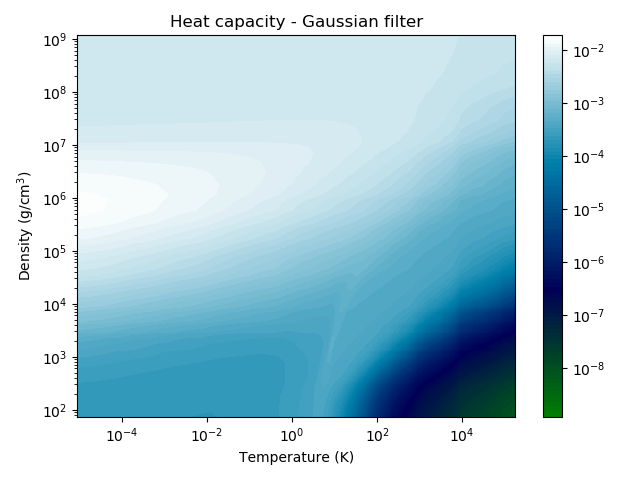

In [91]:

filtered_Cv = gaussian_filter(Cv_on_grid, sigma = 2)  

fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity - Gaussian filter")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_on_grid)),
                     np.log10(np.max(Cv_on_grid)),
                     100)
cplot = ax.contourf(density_points, temp_points, filtered_Cv, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()


<IPython.core.display.Javascript object>


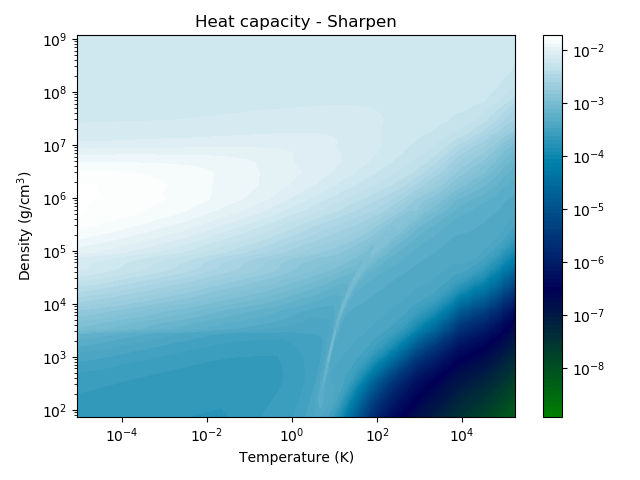

In [98]:
from scipy.ndimage import gaussian_gradient_magnitude

gradient = gaussian_gradient_magnitude(Cv_on_grid, sigma=1.0)

# Add scaled gradient back to original
filtered_Cv = Cv_on_grid + 1.2 * gradient

filtered_Cv = np.clip(filtered_Cv, a_min=1e-12, a_max=None)

# ###Other###
# filtered_Cv = Cv_on_grid**1.05
# filtered_Cv = np.clip(filtered_Cv, a_min=1e-12, a_max=None)

#filtered_Cv = Cv_on_grid/ np.max(Cv_on_grid)


fig, ax = plt.subplots()
locator = ticker.LogLocator(base=10)
fmatter = ticker.LogFormatterSciNotation(base=10)
ax.set_title(r"Heat capacity - Sharpen")
ax.set_ylabel(r"Density (g/cm$^3$)")
ax.set_yscale('log')
ax.set_xlabel(r"Temperature (K)")
ax.set_xscale('log')
levels = np.logspace(np.log10(np.min(Cv_on_grid)),
                     np.log10(np.max(Cv_on_grid)),
                     100)
cplot = ax.contourf(density_points, temp_points, filtered_Cv, levels,
                    cmap='ocean',
                    locator=locator)
clb = plt.colorbar(cplot, format=fmatter, ticks=locator)
ax.set_ylim(np.min(T_grid[T_grid > 0]), np.max(T_grid))
ax.set_xlim(np.min(density_grid[density_grid > 0]), np.max(density_grid))
fig.tight_layout()


## Animate Transformation

# Try different material

In [ ]:
# Set up the P-T table
P_of_RT_Steel = Table('EOS_Pt_DT', 4272) #pressure table as a function of RT, the R stands for rho (density)
e_of_RT_Steel = Table('EOS_Ut_DT', 4272) #internal energy (U) table as a function of RT
P_of_Re_Steel = Table('EOS_Pt_DUt', 4272) #Pressure table as a function of R (density) and e(internal energy)
ecold_of_R_Steel = Table('EOS_Uc_D', 4272) #Loads the cold curve as a function of density e_cold(rho)

# Get the density-temperature grid from SESAME tables
nR, nT = [int(val) for val in P_of_RT_Steel.info_many(['NR', 'NT'])] #getting the nR (number of density points) and nT
T_grid_Steel = np.array(P_of_RT_Steel.info_one('T_Array')) #retrives actual values
density_grid_Steel = np.array(P_of_RT_Steel.info_one('R_Array'))
density_points_Steel, temp_points_Steel = np.meshgrid(density_grid, T_grid_Steel, indexing='ij') #each are nR x nT

# Get the values on the grid
P_on_grid_Steel, _, _ = P_of_RT_Steel.interpolate_many(density_points_Steel.flatten(),
                                           temp_points_Steel.flatten()) #the _, _ just means ignore the other 2 return values
P_on_grid_Steel = P_on_grid_Steel.reshape(nR, nT)
e_on_grid_Steel, dedr_T, dedT_R = e_of_RT_Steel.interpolate_many(density_points_Steel.flatten(),
                                                     temp_points_Steel.flatten()) #finds pressure at every coordinate
e_on_grid_Steel = e_on_grid_Steel.reshape(nR, nT) 
Cv_on_grid_Steel = dedT_R.reshape(nR, nT)

# Get the cold curve. Note that we're interpolating on nR x nT points here.
# Also note that the temperature points are irrelevant
ecold_on_grid_Steel, _, _ = ecold_of_R_Steel.interpolate_many(density_points_Steel.flatten(),
                                                  temp_points_Steel.flatten()) #does the same lookups for energy, interpolates using 4 points
ecold_on_grid_Steel = ecold_on_grid_Steel.reshape(nR, nT)